**Problem Statement**
You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:


*   Credit card / Prepaid card
*   Bank account services
*   Theft/Dispute reporting
*   Mortgages/loans
*   Others

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

**Pipelines that needs to be performed:**
You need to perform the following eight major tasks to complete the assignment:

Data loading

Text preprocessing

Exploratory data analysis (EDA)

Feature extraction

Topic modelling

Model building using supervised learning

Model training and evaluation

Model inference

**Importing the necessary libraries**

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
spc = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

from pprint import pprint

In [2]:
from tqdm.auto import tqdm
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

tqdm.pandas()

In [3]:
spc = spacy.load('en_core_web_sm')

In [10]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/complaints-2021-05-14_08_16.json'

with open(file_path, 'r') as f:
    data = json.load(f)
df = pd.json_normalize(data)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **DATA PREPARATION**

In [11]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [12]:
# print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [13]:
new_col = {x: x[1:].replace('source.', '').replace('_what_happened', '') for x in df.columns}
df = df.rename(columns=new_col)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [14]:
# Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].apply(lambda x: np.nan if x == '' else x)
df['complaint'].isna().sum()

57241

In [15]:
df.shape

(78313, 22)

In [16]:
# Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])
df.shape

(21072, 22)

 **Prepare the text for topic modeling
Once you have removed all the blank complaints, you need to:**

Make the text lowercase


Remove text in square brackets

Remove punctuation

Remove words containing numbers

 **Once you have done these cleaning operations you need to perform the following:**

Lemmatize the texts
Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].

In [17]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess_txt(text):
    text = text.lower()
    output = []
    for word in text.split():
        if (word[0] == '[' and word[-1] == ']'):
            continue
        if re.search("[0-9]", word):
            continue
        output.append(word)
    text = " ".join(output)
    text = re.sub("[^a-z0-9 ]", "", text)
    return text

In [18]:
#Write your function to Lemmatize the texts

text = "Test, Text 1234 test12 [Test] [Test @test"
assert preprocess_txt(text) == 'test text test test'

In [24]:
# Write your function to Lemmatize the texts
def lemmatize_text(text):
    text = preprocess_txt(text)
    doc = spc(text)
    output = []
    for token in doc:
        output.append(token.lemma_)
    return " ".join(output)

text = "Apples and oranges are similar. John ate the apples."
lemmatize_text(text)

'apple and orange be similar john eat the apple'

In [25]:
# Create a dataframe('cleaned_df') that will have only the complaints and the lemmatized complaints
cleaned_df = df[['complaint']].copy()
cleaned_df['complaint_lemma'] = cleaned_df['complaint'].progress_apply(lemmatize_text)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
cleaned_df

,complaint,complaint_lemma
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...


In [33]:
# Write your function to extract the POS tags
def clean_partOS(text):
    doc = spc(text)
    output = []
    for char in doc:
        if char.pos_ == 'NOUN':
            output.append(char.text)
    return " ".join(output)

doc = spc('My name is LOKESH GADEPALLI.')
[(token.text, token.pos_) for token in doc]

[('My', 'PRON'),
 ('name', 'NOUN'),
 ('is', 'AUX'),
 ('LOKESH', 'ADJ'),
 ('GADEPALLI', 'ADJ'),
 ('.', 'PUNCT')]

In [34]:

cleaned_df['complaint_POS_removed'] = cleaned_df['complaint_lemma'].progress_apply(clean_partOS)


100%|██████████| 21072/21072 [15:34<00:00, 22.54it/s]


In [36]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
cleaned_df

,complaint,complaint_lemma,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...


**Exploratory data analysis to get familiar with the data.**


Write the code in this task to perform the following:

Visualise the data according to the 'Complaint' character length
Using a word cloud find the top 40 words by frequency among all the articles after processing the text
Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

<Axes: ylabel='Frequency'>

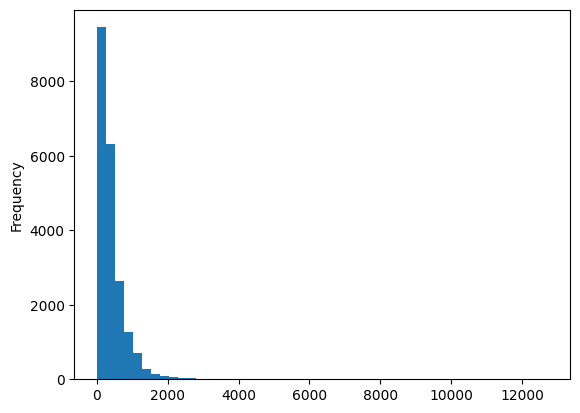

In [38]:
# Write your code here to visualise the data according to the 'Complaint' character length
cleaned_df['complaint_POS_removed'].apply(len).plot.hist(bins=50)

**Find the top 40 words by frequency among all the articles after processing the text.**

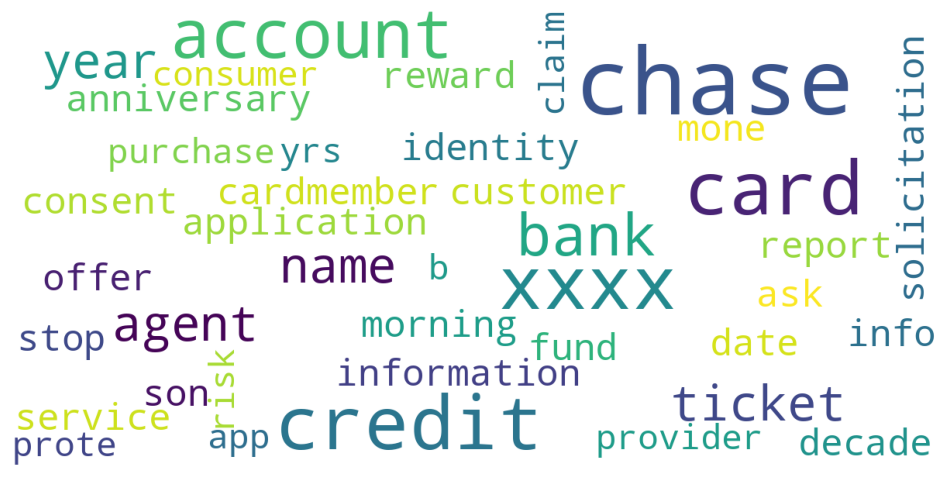

In [39]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)

def show_wordcloud(data, max_words=40, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(cleaned_df['complaint_POS_removed'])

In [40]:
# Removing -PRON- from the text corpus
cleaned_df['Complaint_clean'] = cleaned_df['complaint_POS_removed'].str.replace('-PRON-', '')

In [41]:
corpus = " ".join(cleaned_df['Complaint_clean'])

**Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.**

In [42]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(cleaned_df).
def get_topn_ngrams(corpus, n_gram=1, top_n=30):
    n_grams = nltk.ngrams(corpus.split(), n_gram)
    n_grams = [' '.join(x) for x in n_grams]
    freq = Counter(n_grams)
    return sorted(freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [43]:
# Print the top 10 words in the unigram frequency
get_topn_ngrams(corpus, n_gram=1, top_n=10)

[('chase', 52302),
 ('account', 46671),
 ('xxxx', 44389),
 ('credit', 33454),
 ('card', 30194),
 ('bank', 21366),
 ('payment', 21160),
 ('time', 15993),
 ('charge', 14118),
 ('xxxxxxxx', 13026)]

In [44]:
# Print the top 10 words in the bigram frequency
get_topn_ngrams(corpus, n_gram=2, top_n=10)

[('credit card', 12839),
 ('credit report', 3927),
 ('xxxx xxxx', 3860),
 ('customer service', 3054),
 ('account chase', 2905),
 ('chase credit', 2804),
 ('chase account', 2544),
 ('bank account', 2396),
 ('check account', 2241),
 ('account account', 2153)]

In [45]:
# Print the top 10 words in the trigram frequency
get_topn_ngrams(corpus, n_gram=3, top_n=10)

[('chase credit card', 1896),
 ('credit card account', 1073),
 ('credit card company', 985),
 ('xxxx credit card', 809),
 ('credit card chase', 696),
 ('credit card credit', 492),
 ('inquiry credit report', 489),
 ('xxxx xxxx xxxx', 445),
 ('account credit card', 441),
 ('chase customer service', 383)]

**The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis**

In [46]:
cleaned_df['Complaint_clean'] = cleaned_df['Complaint_clean'].str.replace('xxxx','')

In [47]:
# All masked texts has been removed
cleaned_df

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...


**Feature Extraction¶**

Convert the raw texts to a matrix of TF-IDF features

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words" max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

min_df is used for removing terms that appear too infrequently min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [48]:
# Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 3),
    max_df=0.95,
    min_df=2,
    max_features=5000
)

Create a document term matrix using fit_transform
The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score: The tuples that are not there have a tf-idf score of 0

In [49]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in cleaned_df.
dtm = tfidf.fit_transform(cleaned_df['Complaint_clean'])

In [50]:

tfidf.get_feature_names_out()

array(['ability', 'abuse', 'acceptance', ..., 'yrs', 'zip', 'zip code'],
      dtype=object)

**Topic Modelling using NMF**

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

Find the best number of clusters
Apply the best number to create word clusters
Inspect & validate the correction of each cluster wrt the complaints
Correct the labels if needed
Map the clusters to topics/cluster names

**Manual Topic Modeling**

You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [51]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

# keep the random_state =40
nmf_model = NMF(n_components=num_topics, init='random', random_state=40) #write your code here

In [52]:
nmf_model.fit(dtm)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

5000

In [53]:
# Print the Top15 words for each of the topics
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}")
        ax.invert_yaxis()

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=1.5, hspace=0.5)
    plt.show()

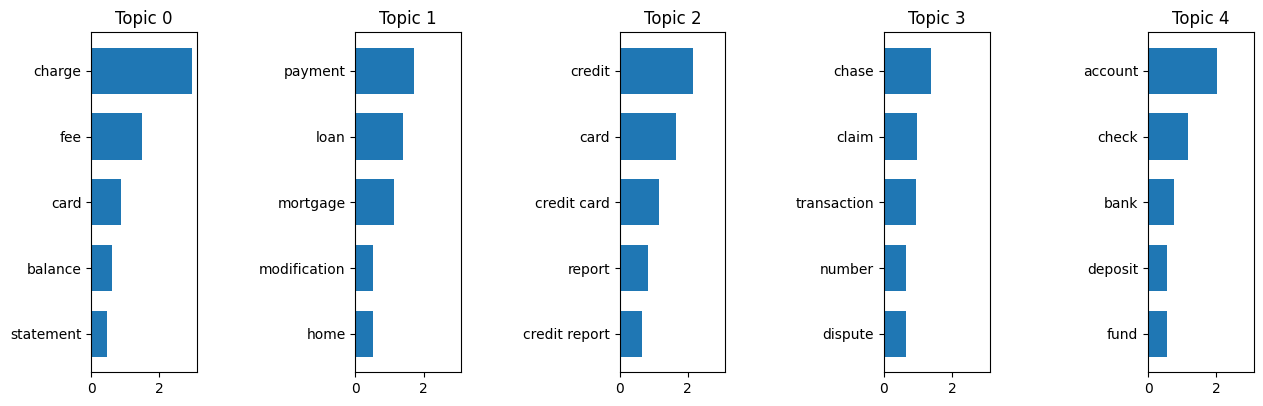

In [54]:
plot_top_words(nmf_model, feature_names, 5)

In [55]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
def get_topic(complaint, tfidf=tfidf, nmf_model=nmf_model):
    tfidf_vector = tfidf.transform([complaint])
    topic_id = nmf_model.transform(tfidf_vector).argmax()
    return topic_id

In [56]:
# Assign the best topic to each of the cmplaints in Topic Column
cleaned_df['Topic'] = cleaned_df['Complaint_clean'].progress_apply(get_topic) #write your code to assign topics to each rows.

100%|██████████| 21072/21072 [00:48<00:00, 435.74it/s]


In [58]:
cleaned_df.head()

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...,2
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,2
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,4


In [59]:
# Print the first 5 Complaint for each of the Topics
cleaned_df_grp = cleaned_df.groupby('Topic').head(5)
cleaned_df_grp.sort_values('Topic')

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
138,"On XX/XX/2019, I submitted a complaint to my b...",on I submit a complaint to my bank jp morgan c...,complaint bank charge debit card bank time dat...,complaint bank charge debit card bank time dat...,0
45,I made a purchase with XXXX XXXX XXXX on XX/XX...,I make a purchase with xxxx xxxx xxxx on in th...,purchase amount charge transaction dispute cas...,purchase amount charge transaction dispute cas...,0
40,"XXXX XXXX a sofa, love seat, table and chairs ...",xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card charge b...,sofa love seat table chair debit card charge b...,0
30,"To whom it may concern, Chase bank charged wro...",to whom it may concern chase bank charge wrong...,bank overdraft fee alert balance fee balance t...,bank overdraft fee alert balance fee balance t...,0
63,I tried to send almost {$2000.00} at XXXX and ...,I try to send almost at xxxx and the transacti...,transaction d charge service refund card account,transaction d charge service refund card account,0
81,I bought a new XXXX XXXX on XX/XX/XXXX from XX...,I buy a new xxxx xxxx on xxxxxxxx from xxxx xx...,xxxx loan title chase time resolution time sta...,loan title chase time resolution time state r...,1
58,I made a purchase of {$260.00} on XX/XX/XXXX. ...,I make a purchase of on xxxxxxxx I make paymen...,purchase xxxxxxxx payment payment closing date...,purchase payment payment closing date stateme...,1
57,I have been trying to do a loan modification w...,I have be try to do a loan modification with c...,loan modification chase payment doc,loan modification chase payment doc,1
73,I have wired through one of Chase branches in ...,I have wire through one of chase branch in xxx...,wire chase branch reinstatement amount order f...,wire chase branch reinstatement amount order f...,1
20,"During the summer months, I experience a decli...",during the summer month I experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,1


**After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:**

Bank Account services

Credit card or prepaid card

Theft/Dispute Reporting

Mortgage/Loan

Others

In [60]:
# Create the dictionary of Topic names and Topics
Topic_names = {
    3: 'Credit card / Prepaid card',
    1: 'Bank account services',
    4: 'Others',
    0: 'Theft/Dispute reporting',
    2: 'Mortgages/loans',
}
# Replace Topics with Topic Names
cleaned_df['Topic'] = cleaned_df['Topic'].map(Topic_names)

In [61]:
cleaned_df

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Others
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,Credit card / Prepaid card
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...,Mortgages/loans
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,Mortgages/loans
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Others
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Mortgages/loans
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,Credit card / Prepaid card
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,Credit card / Prepaid card
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,Mortgages/loans


**Supervised model to predict any new complaints to the relevant Topics.**

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [62]:
# Create the dictionary again of Topic names and Topics

Topic_ids = {y: x for x, y in Topic_names.items()}
# Replace Topics with Topic Names
cleaned_df['Topic'] = cleaned_df['Topic'].map(Topic_ids)

In [63]:
cleaned_df

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,4
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,xxxx agent anniversary date agent information ...,agent anniversary date agent information orde...,3
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,chase card report application identity consent...,chase card report application identity consent...,2
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,xxxx xxxx ticket offer ticket reward card info...,ticket offer ticket reward card information ...,2
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,4
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,2
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...,3
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,risk consumer chase bank app chase year banki...,3
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card chase freedom pro...,credit yrs chase credit card chase freedom pro...,2


In [64]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = cleaned_df[['Complaint_clean', 'Topic']].copy()

In [65]:
training_data

,Complaint_clean,Topic
1,morning name stop bank cardmember service ask ...,4
2,agent anniversary date agent information orde...,3
10,chase card report application identity consent...,2
11,ticket offer ticket reward card information ...,2
14,son chase account fund chase bank account mone...,4
...,...,...
78303,chase card customer decade solicitation credit...,2
78309,credit card provider claim purchase protectio...,3
78310,risk consumer chase bank app chase year banki...,3
78311,credit yrs chase credit card chase freedom pro...,2


**Apply the supervised models on the training data created. In this process, you have to do the following:**

Create the vector counts using Count Vectoriser

Transform the word vecotr to tf-idf

Create the train & test data using the
train_test_split on the tf-idf & topics

In [66]:
# Write your code to get the Vector count
count_vect = CountVectorizer(
    stop_words='english',
    ngram_range=(1, 3),
    max_df=0.95,
    min_df=2,
    max_features=5000
)

X_counts = count_vect.fit_transform(training_data['Complaint_clean'])
X_counts.shape

(21072, 5000)

In [67]:
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_tfidf.shape

(21072, 5000)

In [68]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['Topic'],
                                                    test_size = 0.3,
                                                    random_state = 0)

**You have to try atleast 3 models on the train & test data from these options:**


Logistic regression

Decision Tree

Random Forest

Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [69]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# LogisticRegression
clf_lr = LogisticRegression(max_iter=400)
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [71]:
# df_lr['Model'] = 'LogisticRegression'
model_name = 'lr'
df_lr = pd.DataFrame(
    precision_recall_fscore_support_score,
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)


In [72]:
# DecisionTreeClassifier
clf_dtree = DecisionTreeClassifier()
clf_dtree.fit(X_train, y_train)
y_pred = clf_dtree.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [73]:
# df_dtree['Model'] = 'DecisionTreeClassifier'
model_name = 'dtree'
df_dtree = pd.DataFrame(
    precision_recall_fscore_support_score,
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)


In [74]:
# RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [75]:
# df_rf['Model'] = 'RandomForestClassifier'
model_name = 'rf'
df_rf = pd.DataFrame(
    precision_recall_fscore_support_score,
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)


In [76]:
# MultinomialNB
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [77]:
# df_nb['Model'] = 'MultinomialNB'
model_name = 'nb'
df_nb = pd.DataFrame(
    precision_recall_fscore_support_score,
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)


In [78]:
df_scores = pd.concat([df_lr, df_dtree, df_rf, df_nb])
df_scores = df_scores.T
df_scores = df_scores[[col for col in df_scores.columns if 'f1' in col]]
df_scores

,f1_lr,f1_dtree,f1_rf,f1_nb
Theft/Dispute reporting,0.937558,0.740611,0.823183,0.645527
Bank account services,0.974453,0.866765,0.925027,0.886219
Mortgages/loans,0.966307,0.836708,0.907158,0.854653
Credit card / Prepaid card,0.936495,0.711365,0.832759,0.761194
Others,0.972002,0.851323,0.906157,0.860859


**LogisticRegression has the best F1 scores across all topics/classes.**

In [82]:
# Function to validate text input
def validate_text(input_text):
    if not isinstance(input_text, str) or not input_text.strip():
        raise ValueError("Input text must be a non-empty string.")
    return input_text

# Example functions (placeholders for your actual implementations)
def lemmatize_text(text):
    # Add your lemmatization logic here
    return text.lower()  # Example transformation

def clean_pos(text):
    # Add your part-of-speech cleaning logic here
    return text  # Example transformation

# Test complaint text
try:
    complaint_text = 'I want to increase my EMI amount for home loan account number 12345678.'

    #  Validate input
    complaint_text = validate_text(complaint_text)

    #  Apply preprocessing
    complaint_text = lemmatize_text(complaint_text)
    complaint_text = clean_pos(complaint_text)

    #  Vectorization
    complaint_vec = count_vect.transform([complaint_text])
    complaint_vec = tfidf_transformer.transform(complaint_vec)

    #  Prediction
    pred = clf_lr.predict(complaint_vec)
    print(f"Predicted Class: {Topic_names[pred[0]]}")

except ValueError as e:
    print(f"Input Error: {e}")
except Exception as e:
    print(f"Unexpected Error: {e}")


Predicted Class: Bank account services


**Conclusion :**

Logistic Regression has highest accuracy of **0.9744** for predicted class as **Bank account services**, Which makes it a best model fit.